In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as ku
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
data = open('data.txt', encoding = 'utf = 8').read()

corpus = data.split('\n')
corpus

['नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,',
 'मनको वनमा ननिभ्ने गरी विरह जलाई !',
 'ननिभ्ने गरी विरह जलाई,',
 'लोचनका तारा ! हे मेर प्यारा ! यो जोति  बिलाए !',
 'के भनूँ? भन्ने म केही थिइन  विष नै पिलाए !',
 'प्यारा ! विष नै पिलाए !',
 'मनको कुरा गलामा अड्छ, अड्कन्छ गलामा,',
 'यो मेरो मुटु पचासबाजी धड्कन्छ पलामा ।',
 'यो छाती मेरो चिरेर खोली नजर गराए,',
 'त्यो मन केही फर्कंदो होला, तस्विर खुलाए',
 'आँसुमा खस्छ मनको टुक्रा यो आँसु बोल्दैन,',
 'मनको कुरा मनमै बस्छ, छातिले खोल्दैन,',
 'प्यारा ! आँसुले बोल्दैन !',
 'हे मेरी मुना ! नभन त्यसो, जूनमा फुलेकी !',
 'फर्कन्छु फेरि म चाँडै भन्ने किन हो भुलेकी ?',
 'म बीसै दिन बसुँला ल्हासा, बाटामा बीसै दिन्,',
 'चखेवा फेरी आउँछ उडी बिहान कुनै दिन्,',
 'प्यारी ! भेटको बडा दिन !',
 'कि मरिछाड्यो, कि गरिछाड्यो मर्दको इरादा,',
 'नहाल प्यारि ! बाटामा मेरो आँसुको यो बाधा ।',
 'अनार दाना दाँतका लहर खोलेर हाँसन्,',
 'तिमीले हाँसे म हाँक्न सक्छु ईन्द्रको आसन ।',
 'प्यारी ! बिदामा हाँसन ',
 'हे मेरा राम ! हे मेरा कृष्ण ! जङ्गल, पहाड,',
 'भीरका भोटे, वनका ज

In [3]:
len(corpus)

4092

In [4]:
cleaned_corpus = []
tokenizer = Tokenizer()

for line in corpus:
    res = re.sub('[!,*)@।#%(&$_?.^]', '', line)
    cleaned_corpus.append(res)
    
tokenizer.fit_on_texts(cleaned_corpus)
total_words = len(tokenizer.word_index) + 1 

In [5]:
cleaned_corpus[:10]

['नछाडी जानोस् हे मेरा प्राण  अकेली मलाई',
 'मनको वनमा ननिभ्ने गरी विरह जलाई ',
 'ननिभ्ने गरी विरह जलाई',
 'लोचनका तारा  हे मेर प्यारा  यो जोति  बिलाए ',
 'के भनूँ भन्ने म केही थिइन  विष नै पिलाए ',
 'प्यारा  विष नै पिलाए ',
 'मनको कुरा गलामा अड्छ अड्कन्छ गलामा',
 'यो मेरो मुटु पचासबाजी धड्कन्छ पलामा ',
 'यो छाती मेरो चिरेर खोली नजर गराए',
 'त्यो मन केही फर्कंदो होला तस्विर खुलाए']

In [6]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## Tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1 
    
    # convert data to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(cleaned_corpus)

In [7]:
print(len(inp_sequences))
inp_sequences[:5]

14827


[[1337, 2623],
 [1337, 2623, 12],
 [1337, 2623, 12, 39],
 [1337, 2623, 12, 39, 103],
 [1337, 2623, 12, 39, 103, 628]]

In [8]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes = total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [9]:
max_sequence_len

11

In [10]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1 
    
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_sequence_len))
    model.add(Bidirectional(LSTM(150, return_sequences = True)))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    
    model.add(Dense(total_words / 2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
    model.add(Dense(total_words, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           861300    
_________________________________________________________________
bidirectional (Bidirectional (None, 11, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 11, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 4306)              434906    
_________________________________________________________________
dense_1 (Dense)              (None, 8613)              37096191  
Total params: 38,853,997
Trainable params: 38,853,997
Non-trainable params: 0
____________________________________________

In [11]:
history = model.fit(predictors, label, epochs = 100, verbose = 1)

Epoch 1/100
464/464 [==============================] - 221s 459ms/step - loss: 8.9733 - accuracy: 0.0132
Epoch 2/100
464/464 [==============================] - 240s 518ms/step - loss: 8.2016 - accuracy: 0.0137
Epoch 3/100
464/464 [==============================] - 220s 474ms/step - loss: 8.0086 - accuracy: 0.0147
Epoch 4/100
464/464 [==============================] - 244s 527ms/step - loss: 7.8981 - accuracy: 0.0157
Epoch 5/100
464/464 [==============================] - 243s 524ms/step - loss: 7.7712 - accuracy: 0.0134
Epoch 6/100
464/464 [==============================] - 223s 480ms/step - loss: 7.6347 - accuracy: 0.0152
Epoch 7/100
464/464 [==============================] - 227s 489ms/step - loss: 7.5662 - accuracy: 0.0134
Epoch 8/100
464/464 [==============================] - 221s 475ms/step - loss: 7.4596 - accuracy: 0.0143
Epoch 9/100
464/464 [==============================] - 231s 499ms/step - loss: 7.3474 - accuracy: 0.0139
Epoch 10/100
464/464 [==============================] -

464/464 [==============================] - 176s 379ms/step - loss: 1.4159 - accuracy: 0.7963
Epoch 73/100
464/464 [==============================] - 177s 380ms/step - loss: 1.3981 - accuracy: 0.8016
Epoch 74/100
464/464 [==============================] - 176s 379ms/step - loss: 1.3700 - accuracy: 0.7986
Epoch 75/100
464/464 [==============================] - 176s 380ms/step - loss: 1.3637 - accuracy: 0.7999
Epoch 76/100
464/464 [==============================] - 176s 379ms/step - loss: 1.3375 - accuracy: 0.8042
Epoch 77/100
464/464 [==============================] - 176s 379ms/step - loss: 1.3055 - accuracy: 0.8155
Epoch 78/100
464/464 [==============================] - 176s 379ms/step - loss: 1.2671 - accuracy: 0.8172
Epoch 79/100
464/464 [==============================] - 176s 379ms/step - loss: 1.2272 - accuracy: 0.8278
Epoch 80/100
464/464 [==============================] - 176s 379ms/step - loss: 1.2037 - accuracy: 0.8299
Epoch 81/100
464/464 [==============================] - 176

In [18]:
! pip install pydotplus

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 278 kB 493 kB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=334809090b7eb998ca01916f9e6b1316e6178c047869d27f69bbe6640ef1954a
  Stored in directory: /home/linus/.cache/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [21]:
tf.keras.utils.plot_model(
    model,
    to_file="model.jpg",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [23]:
model.save('my_model.h5')

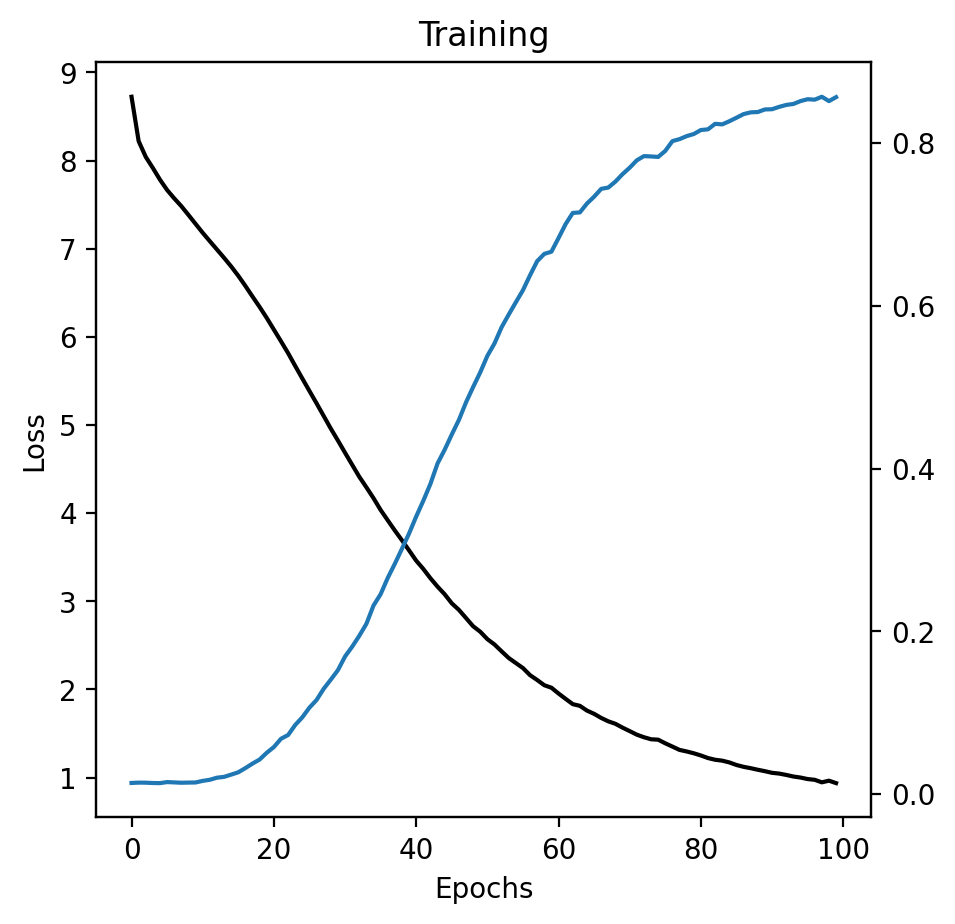

In [26]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True , figsize=(5,5) , dpi = 200)
ax.set(title="Training")
ax11 = ax.twinx()
ax.plot(history.history['loss'], color='black')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(history.history[metric], label=metric)
plt.show()

########################################### TESTING THE MODEL OUTPUT ###########################################

In [27]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [28]:
print (generate_text("मनको", 5, model, max_sequence_len))
print (generate_text("आमा", 5, model, max_sequence_len))
print (generate_text("माया", 5, model, max_sequence_len))
print (generate_text("तिमी", 5, model, max_sequence_len))
# print (generate_text("new york", 4, model, max_sequence_len))
# # print (generate_text("science and technology", 5, model, max_sequence_len))

मनको बत्ती तनको बली स्वर्ग छ
आमा कलेजा जल्दछ छयाङ्ग बिहानले सलिल
माया हाम्रो मदिर–अधर उनका चिराक पल्तिर
तिमी नजीक काल के म काल
